# Parts Distributor SKU classifier, part 2: Explore the model

In [part 1](parts-distributor-sku-classifier-part-1.ipynb) we built a model that can classify strings like `SN74LVC541APWR` or `296-8521-1-ND` as either manufacturer part numbers, Mouser SKUs or Digi-Key SKUs. In part 2, we will load that model and run it on various inputs to get a feel for how it works.

## Load the model

First let's load the model and the training data back into memory.

In [1]:
import pandas as pd
import numpy as np
import json
from IPython.display import Markdown, display
from keras.models import model_from_json
from collections import defaultdict, Counter
import graphviz
from IPython.display import SVG

Using TensorFlow backend.


In [2]:
# Load the model architecture
with open("data/trained_model_layers.json", 'r') as json_file:
    model = model_from_json(json_file.read())

# Load the model weights
model.load_weights("data/trained_model_weights.h5")

# Compile the model
batch_size = 32
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Load the data set
df = pd.read_json("data/cleaned_training_data.json")

# Load the dictionary
with open("data/char_dictionary.json", 'r') as json_file:
    partnum_dict = json.load(json_file)
    
class_names = ['MPN', 'Mouser SKU', 'Digi-Key SKU']

def d(col, ds, class_filter=None, df=df):
    if class_filter is not None:
        return list(df[(df['dataset'] == ds) & (df['class'] == class_filter)][col])
    else:
        return list(df[df['dataset'] == ds][col])
    
df.head()

,class,dataset,partnum,x,y
0,2,train,296-8311-6-ND,"[38, 34, 6, 37, 43, 26, 47, 47, 37, 6, 37, 14,...","[0.0, 0.0, 1.0]"
1,2,train,MCP1702T-3302E/CBCT-ND,"[21, 4, 24, 47, 12, 1, 38, 3, 37, 26, 26, 1, 3...","[0.0, 0.0, 1.0]"
10,1,val,595-TPS65986ABZQZR,"[23, 34, 23, 37, 3, 24, 19, 6, 23, 34, 43, 6, ...","[0.0, 1.0, 0.0]"
100,2,train,A109694TR-ND,"[13, 47, 1, 34, 6, 34, 7, 3, 16, 37, 14, 15, 0...","[0.0, 0.0, 1.0]"
1000,2,train,LP5900SD-3.0/NOPBCT-ND,"[39, 24, 23, 34, 1, 1, 19, 15, 37, 26, 28, 1, ...","[0.0, 0.0, 1.0]"


In [3]:
# Test the model to make sure it's loaded correctly
score, acc = model.evaluate(d('x', 'val'), d('y', 'val'), batch_size=batch_size)
display(Markdown('### Accuracy of the model: {:.2f}%'.format(acc * 100.0)))
res = []
for c in sorted(df['class'].unique()):
    score, acc = model.evaluate(d('x', 'val', class_filter=c), d('y', 'val', class_filter=c), batch_size=batch_size)
    res.append([class_names[c], '{:.2f}%'.format(acc*100.0)])
pd.DataFrame(res, columns=['class', 'accuracy'])

2720/2789 [============================>.] - ETA: 0s

### Accuracy of the model: 98.96%

864/921 [===========================>..] - ETA: 0s

,class,accuracy
0,MPN,97.46%
1,Mouser SKU,99.40%
2,Digi-Key SKU,100.00%


The model is miscategorizing some of the MPNs. Let's visualize the confusion.

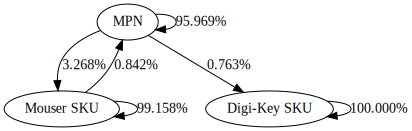

In [4]:
def cross_category_bleeding(model, x_test, y_test, batch_size):
    preds = model.predict(x_test)
    cat_count = np.shape(y_test)[1]
    r = np.zeros((cat_count, cat_count))
    for x, y, pred in zip(x_test, y_test, preds):
        class_being_tested = np.argmax(y)
        class_predicted = np.argmax(pred)
        r[class_being_tested][class_predicted] += 1
    # split array into rows
    # normalize each row
    # stack rows back into one array
    return np.stack([v/np.sum(a) if v else 0 for v in a] for a in np.split(r.flatten(), cat_count))

def graphviz_cross_category_diagram(res_matrix, class_labels=[]):
    graph = graphviz.Digraph()
    label = lambda c: class_labels[c] if len(class_labels) > c else 'Category {}'.format(c)
    node_name = lambda c: 'C{}'.format(c)
    for true_c in range(len(res_matrix)):
        graph.node(node_name(true_c), label(true_c))
        preds = res_matrix[true_c]
        for pred_c in range(len(preds)):
            acc = res_matrix[true_c][pred_c] * 100.0
            if acc > 0:
                acc_str = '{:.3f}%'.format(acc)
                graph.edge(node_name(true_c), node_name(pred_c), acc_str)
    return graph

r = cross_category_bleeding(model, d('x', 'val'), d('y', 'val'), batch_size)
g = graphviz_cross_category_diagram(r, class_names)
SVG(g.pipe(format='svg'))

(Arrows indicate results of categorization, i.e. `Mouser SKU -> MPN` means that some samples that we know for sure are Mouser SKUs got categorized as MPNs by the model).

The main thing this diagram is telling us is that the Mouser SKU classifier has a bit of a "false positives" problem with MPNs. The MPN class is a noisy catch-all without discernible patterns, so it's not entirely realistic to expect this kind of a model to learn something as nebulous - the best we can hope for is that the model learns all well-defined classes really well, and the one noisy "leftovers" class takes care of itself. ([More on this "I don't know this data" problem here.](https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd))

To better understand what's happening under the hood, let's run some examples through the model one character at a time. Let's also define a bunch of extra columns on the data frame to save keystrokes later.

In [5]:
preds = model.predict(list(df['x']))
df['predicted_class'] = list(np.argmax(y) for y in preds)
df['predicted_values'] = list(y for y in preds)
df['true_class_mpn'] = (df['class'] == 0)
df['true_class_mouser'] = (df['class'] == 1)
df['true_class_digikey'] = (df['class'] == 2)
df['pred_class_mpn'] = (df['predicted_class'] == 0)
df['pred_class_mouser'] = (df['predicted_class'] == 1)
df['pred_class_digikey'] = (df['predicted_class'] == 2)

df[df.true_class_mpn & df.pred_class_mouser].head(10)[['partnum', 'predicted_values']]

,partnum,predicted_values
10031,2-1734592-4,"[0.346436, 0.643273, 1.61759e-05]"
10331,T495D157K010ATE100,"[0.0200557, 0.983498, 0.000113192]"
10598,ST-4ETB204,"[0.463033, 0.516922, 1.56907e-05]"
10641,68000-416HLF,"[0.46751, 0.512723, 1.58005e-05]"
10656,N2514-6V0C-RB-WD,"[0.169638, 0.833444, 2.20232e-05]"
10761,68001-204HLF,"[0.455674, 0.52555, 1.57317e-05]"
10835,2-84953-5,"[0.477399, 0.501284, 1.58988e-05]"
10848,7A-12.000MAAE-T,"[0.321224, 0.66895, 1.68481e-05]"
10990,NPA-700B-015A,"[0.158344, 0.849748, 2.22618e-05]"
11094,2000-1-2-41-00-BK,"[0.03868, 0.96673, 6.12098e-05]"


Let's take a look at `DF14-15P-1.25H(55)` - this is very clearly not a Mouser SKU because those usually begin with a group of digits followed by a dash, never with characters. We are going to run this through the model one character at a time and plot the classifier output along the way.

(As a reminder, all Mouser SKUs start with a few digits followed by a dash, like `595-TPS65986ABZQZR` or `576-SP4024-01FTG-C` and DON'T END with "`-ND`" because that's Digi-Key's territory. Like I said, this is a bit of a toy problem).

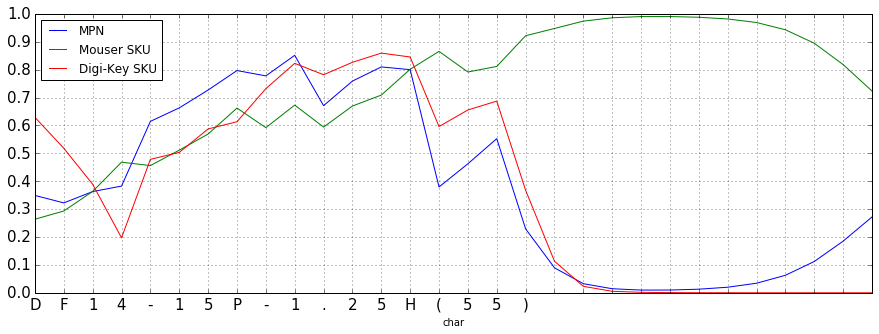

In [6]:
def char_by_char_classification_plot(partnum):
    x = df[df['partnum'] == partnum].iloc[0]['x']
    x_steps = [np.array(x[:i]) for i in range(1, len(x))]
    step_preds = []
    for i, x_step in enumerate(x_steps):
        c = partnum[i] if i < len(partnum) else ''
        pred = model.predict(np.array(x_step, ndmin=2))
        step_preds.append([c] + [v for v in pred.flat])
    df_res = pd.DataFrame(step_preds, columns=['char'] + class_names)
    return df_res.plot.line(x='char', grid=True, fontsize=15, xticks=range(len(x)-1), yticks=[0.1*v for v in range(11)], figsize=(15, 5))

char_by_char_classification_plot('DF14-15P-1.25H(55)')

The classifier starts off well with a healthy dose of pessimism. But then its confidence in this being a Mouser SKU steadily grows, aided by some significant drops in confidence in other classes along the way, around characters '.' and '('.

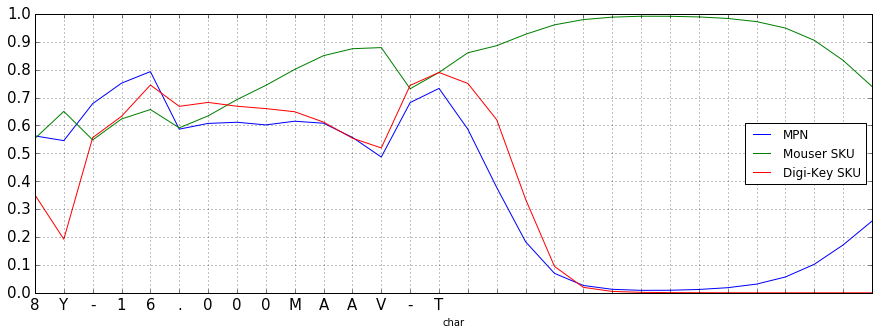

In [7]:
char_by_char_classification_plot('8Y-16.000MAAV-T')

Here we begin a strong bet on the Mouser SKU class because of the digit "8" leading the sequence. The following letter "Y" should greatly diminish our hopes, but that doesn't happen.

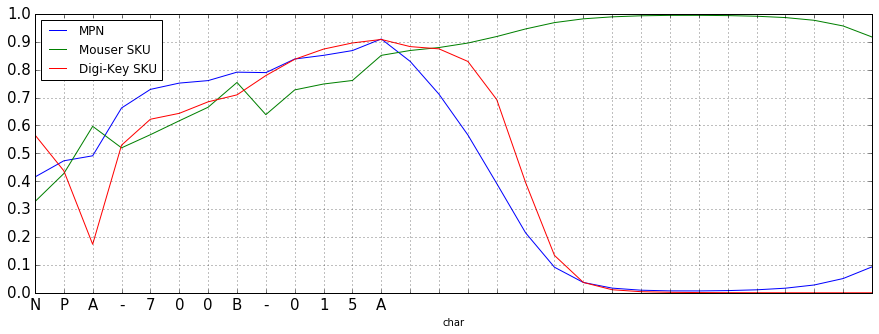

In [8]:
char_by_char_classification_plot('NPA-700B-015A')

Something similar to case 1 here: starts off smart, finishes not so much. There is no way it should be thinking about Mouser SKUs at a ridiculously high confidence level of 0.6 when there's a letter before the first dash!

This is where a doubt creeps in: does this model have the concept of "the beginning of the string"? We do have an "end of sequence" token - that's what we use to end and pad every sequence. What would happen if we introduced an explicit "start of sequence" token - could that eliminate some of these false positives?

Let's do that in [part 3](parts-distributor-sku-classifier-part-3-better-model.ipynb) of the series.